In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 21.9 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import mne
import json
# from AudioOnsetUtils import *
import tensorflow as tf
from keras.utils import plot_model

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import SpectralEmbedding
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
PNUMs=['01','04','06','07','09','11','12','13','14']

In [ ]:
mega_eeg_list=[]
mega_audio_list=[]
mega_song_id_list = []
for PNUM in PNUMs:
  eeg_dir = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/64_InputChannels/Sub"+PNUM+"/P"+PNUM+"-formatted.json"
  # prediction_dir = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/eeg/Testing/64Hz_vlaai_temp/P" + PNUM + '-predictions.json'
  with open(eeg_dir, 'r') as file_x:
    sub_eeg_dict=json.load(file_x)

  x_list+= [value for value in sub_eeg_dict.values()]

  file_path = "/content/drive/MyDrive/CAPSTONE_626_645_648_651/Data/OpenMIIR/audio/pretrained_vlaai_envelope/audio-envelope-formatted.json"
  # os.makedirs(prediction_dir, exist_ok=True)
  with open(file_path, 'r') as file_x:
    env_dict=json.load(file_x)


  for key,value in sub_eeg_dict.items():
    song_id=key.split('_')[1]
    if PNUM in ['01','04','06','07'] and song_id in ['s1','s2','s11','s12','s22']:
      env_key=song_id+'_v1'
    else:
      env_key=song_id+'_v2'
    mega_audio_list.append(env_dict[env_key])
    mega_song_id_list.append(song_id)


In [ ]:
print(len(mega_eeg_list))
print(len(mega_song_id_list))

900
900


Dense Model - Training without SCE

In [ ]:
def pearson_tf(y_true, y_pred, axis=1):
    """Pearson correlation function implemented in tensorflow.

    Parameters
    ----------
    y_true: tf.Tensor
        Ground truth labels. Shape is (batch_size, time_steps, n_features)
    y_pred: tf.Tensor
        Predicted labels. Shape is (batch_size, time_steps, n_features)
    axis: int
        Axis along which to compute the pearson correlation. Default is 1.

    Returns
    -------
    tf.Tensor
        Pearson correlation.
        Shape is (batch_size, 1, n_features) if axis is 1.
    """
    print("\nentered pearson tf")
    # Compute the mean of the true and predicted values
    y_true_mean = tf.reduce_mean(y_true, axis=axis, keepdims=True)
    y_pred_mean = tf.reduce_mean(y_pred, axis=axis, keepdims=True)


    print("\nhello")
    print("y_true.shape ",y_true.shape)
    print("y_pred.shape ",y_pred.shape)
    print("y_true_mean.shape ", y_true_mean.shape)
    print("y_pred_mean.shape ", y_pred_mean.shape)
    # Compute the numerator and denominator of the pearson correlation
    numerator = tf.reduce_sum(
        (y_true - y_true_mean) * (y_pred - y_pred_mean),
        axis=axis,
        keepdims=True,
    )
    print("\nhello2")

    std_true = tf.reduce_sum(tf.square(y_true - y_true_mean), axis=axis, keepdims=True)
    std_pred = tf.reduce_sum(tf.square(y_pred - y_pred_mean), axis=axis, keepdims=True)
    denominator = tf.sqrt(std_true * std_pred)
    print("\nexiting pearson tf")

    # Compute the pearson correlation
    return tf.math.divide_no_nan(numerator, denominator)


In [ ]:
@tf.function
def pearson_loss(y_true, y_pred, axis=1):
    """Pearson loss function.

    Parameters
    ----------
    y_true: tf.Tensor
        True values. Shape is (batch_size, time_steps, n_features)
    y_pred: tf.Tensor
        Predicted values. Shape is (batch_size, time_steps, n_features)

    Returns
    -------
    tf.Tensor
        Pearson loss.
        Shape is (batch_size, 1, n_features)
    """
    return -pearson_tf(y_true, y_pred, axis=axis)



In [ ]:
@tf.function
def pearson_metric(y_true, y_pred, axis=1):
    """Pearson metric function.

    Parameters
    ----------
    y_true: tf.Tensor
        True values. Shape is (batch_size, time_steps, n_features)
    y_pred: tf.Tensor
        Predicted values. Shape is (batch_size, time_steps, n_features)

    Returns
    -------
    tf.Tensor
        Pearson metric.
        Shape is (batch_size, 1, n_features)
    """
    return pearson_tf(y_true, y_pred, axis=axis)

In [ ]:
def pearson_correlation(y_true, y_pred):
    """
    Calculate Pearson correlation coefficient between y_true and y_pred.

    Parameters:
    - y_true: True target values.
    - y_pred: Predicted target values.

    Returns:
    - Pearson correlation coefficient (r) between y_true and y_pred.
    """
    # Calculate Pearson correlation coefficient
    correlation, _ = pearsonr(np.ravel(y_true), np.ravel(y_pred))
    return correlation

In [ ]:
def extractor(
    filters=(256, 256, 256, 128, 128),
    kernels=(8,) * 5,
    input_channels=64,
    normalization_fn=lambda x: tf.keras.layers.LayerNormalization()(x),
    activation_fn=lambda x: tf.keras.layers.LeakyReLU()(x),
    name="extractor",
):
    """Construct the extractor model.

    Parameters
    ----------
    filters: Sequence[int]
        Number of filters for each layer.
    kernels: Sequence[int]
        Kernel size for each layer.
    input_channels: int
        Number of EEG channels in the input
    normalization_fn: Callable[[tf.Tensor], tf.Tensor]
        Function to normalize the contents of a tensor.
    activation_fn: Callable[[tf.Tensor], tf.Tensor]
        Function to apply an activation function to the contents of a tensor.
    name: str
        Name of the model.

    Returns
    -------
    tf.keras.models.Model
        The extractor model.
    """
    eeg = tf.keras.layers.Input((None, input_channels))

    x = eeg

    if len(filters) != len(kernels):
        raise ValueError("'filters' and 'kernels' must have the same length")

    # Add the convolutional layers
    for filter_, kernel in zip(filters, kernels):
        x = tf.keras.layers.Conv1D(filter_, kernel)(x)
        x = normalization_fn(x)
        x = activation_fn(x)
        x = tf.keras.layers.ZeroPadding1D((0, kernel - 1))(x)

    return tf.keras.models.Model(inputs=[eeg], outputs=[x], name=name)

In [ ]:
def output_context(
    filter_=2,
    kernel=1,
    input_channels=2,
    normalization_fn=lambda x: tf.keras.layers.LayerNormalization()(x),
    activation_fn=lambda x: tf.keras.layers.LeakyReLU()(x),
    name="output_context_model",
):
    """Construct the output context model.

    Parameters
    ----------
    filter_: int
        Number of filters for the convolutional layer.
    kernel: int
        Kernel size for the convolutional layer.
    input_channels: int
        Number of EEG channels in the input.
    normalization_fn: Callable[[tf.Tensor], tf.Tensor]
        Function to normalize the contents of a tensor.
    activation_fn: Callable[[tf.Tensor], tf.Tensor]
        Function to apply an activation function to the contents of a tensor.
    name: str
        Name of the model.

    Returns
    -------
    tf.keras.models.Model
        The output context model.
    """
    inp = tf.keras.layers.Input((None, input_channels))
    x = tf.keras.layers.ZeroPadding1D((kernel - 1, 0))(inp)
    x = tf.keras.layers.Conv1D(filter_, kernel)(x)
    x = normalization_fn(x)
    x = activation_fn(x)
    return tf.keras.models.Model(inputs=[inp], outputs=[x], name=name)

In [ ]:
# def vlaai(
#     nb_blocks=4,
#     extractor_model=None,
#     output_context_model=None,
#     use_skip=True,
#     input_channels=2,
#     output_dim=1,
#     name="vlaai",
# ):
#     """Construct the VLAAI model.

#     Parameters
#     ----------
#     nb_blocks: int
#         Number of repeated blocks to use.
#     extractor_model: Callable[[tf.Tensor], tf.Tensor]
#         The extractor model to use.
#     output_context_model: Callable[[tf.Tensor], tf.Tensor]
#         The output context model to use.
#     use_skip: bool
#         Whether to use skip connections.
#     input_channels: int
#         Number of EEG channels in the input.
#     output_dim: int
#         Number of output dimensions.
#     name: str
#         Name of the model.

#     Returns
#     -------
#     tf.keras.models.Model
#         The VLAAI model.
#     """
#     if extractor_model is None:
#         extractor_model = extractor()
#     if output_context_model is None:
#         output_context_model = output_context()

#     eeg = tf.keras.layers.Input((None, input_channels))

#     # If using skip connections: start with x set to zero
#     if use_skip:
#         x = tf.zeros_like(eeg)
#     else:
#         x = eeg

#     # Iterate over the blocks
#     for i in range(nb_blocks):
#         if use_skip:
#             x = extractor_model(eeg + x)
#         else:
#             x = extractor_model(x)
#         x = tf.keras.layers.Dense(input_channels)(x)
#         x = output_context_model(x)

#     x = tf.keras.layers.Dense(output_dim)(x)
#     x = tf.keras.layers.Reshape((618,1))(x)
#     print("x.shape",x.shape)

#     return tf.keras.models.Model(inputs=[eeg], outputs=[x], name=name)

# model = vlaai()
# model.compile(tf.keras.optimizers.Adadelta(), loss=pearson_loss, metrics=[pearson_metric])

In [ ]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D,Conv1D, MaxPooling2D,MaxPooling1D

In [ ]:
linear_model = Sequential([
    Flatten(input_shape=(900, 2)),  # Flatten the input
    Dense(618, activation='linear')  # Linear decoder layer
])
# Compile the model
linear_model.compile(optimizer='adam', loss=pearson_loss, metrics=[pearson_metric])  # Use Mean Squared Error as the loss function

# Print a summary of the model architecture
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1800)              0         
                                                                 
 dense (Dense)               (None, 618)               1113018   
                                                                 
Total params: 1113018 (4.25 MB)
Trainable params: 1113018 (4.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Define your model
dense_model = Sequential([
    # Input layer: Flatten the input
    Flatten(input_shape=(618,64)),

    # # Add a Convolutional Layer
    # Conv2D(32, (3, 3), activation='relu', padding='same'),
    # MaxPooling2D((2, 2)),

    # # Add another Convolutional Layer
    # Conv2D(64, (3, 3), activation='relu', padding='same'),
    # MaxPooling2D((2, 2)),

    # # Flatten the output of the CNN stack
    # Flatten(),


    # Add dense layers (fully connected layers)
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),


    # Linear decoder layer
    Dense(618, activation='linear')
])

# Compile the model and specify loss, optimizer, and metrics
dense_model.compile(optimizer='Adam', loss=pearson_loss, metrics=[pearson_metric])

# Summary of the model architecture
dense_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 39552)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               20251136  
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 618)               158826    
                                                                 
Total params: 20541290 (78.36 MB)
Trainable params: 20541290 (78.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


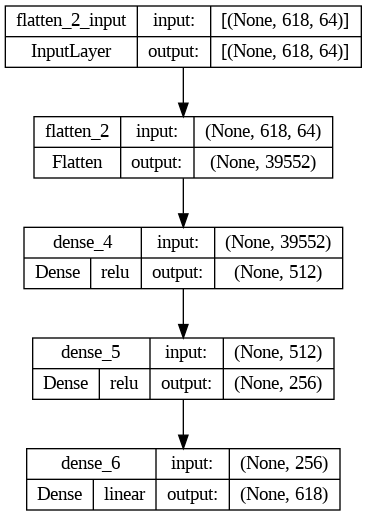

In [ ]:
plot_model(dense_model, to_file='model.png',expand_nested=True,show_shapes=True,show_layer_activations=True,show_layer_names=True)

In [ ]:
# Define the CNN cnn_model
# Define the CNN cnn_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
cnn_model = Sequential([
    # Input layer: Convolutional layers
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(618,64)),
    MaxPooling1D(pool_size=2),

    # Add more convolutional layers or additional max-pooling layers as needed
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    # Flatten the output from the CNN layers
    Flatten(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(618, activation='linear')  # Linear decoder layer
])

# Compile the cnn_model and specify loss, optimizer, and metrics
cnn_model.compile(optimizer='Adam', loss=pearson_loss, metrics=[pearson_metric])

# Summary of the cnn_model architecture
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 616, 32)           6176      
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 308, 32)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 306, 64)           6208      
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 153, 64)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 9792)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

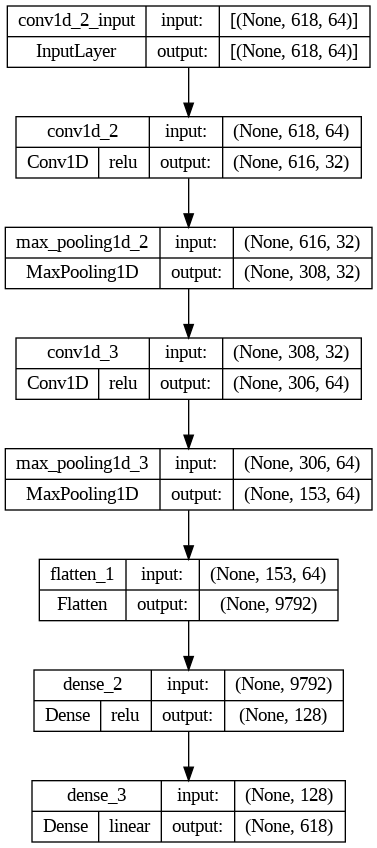

In [ ]:
plot_model(cnn_model, to_file='model.png',show_shapes=True,show_layer_activations=True,show_layer_names=True)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define the CNN cnn_model
cnn_model = Sequential([
    # Input layer: Convolutional layers
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(618, 64, 1)),
    MaxPooling2D(pool_size=(2, 2)),

    # Add more convolutional layers or additional max-pooling layers as needed
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output from the CNN layers
    Flatten(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dense(618, activation='linear')  # Linear decoder layer
])

# Compile the cnn_model and specify loss, optimizer, and metrics
cnn_model.compile(optimizer='Adam', loss=pearson_loss, metrics=[pearson_metric])

# Summary of the cnn_model architecture
cnn_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 616, 62, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 308, 31, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 306, 29, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 153, 14, 64)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 137088)            0         
                                                                 
 dense_6 (Dense)             (None, 128)              

In [ ]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import random

yay
Epoch 1/50
23/23 [==============================] - ETA: 0s - loss: -0.2410 - pearson_metric: 0.2410

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


23/23 [==============================] - 86s 4s/step - loss: -0.2410 - pearson_metric: 0.2410 - val_loss: -0.3349 - val_pearson_metric: 0.3349
Epoch 2/50
23/23 [==============================] - 58s 3s/step - loss: -0.3407 - pearson_metric: 0.3407 - val_loss: -0.3439 - val_pearson_metric: 0.3439
Epoch 3/50
23/23 [==============================] - 55s 2s/step - loss: -0.3458 - pearson_metric: 0.3458 - val_loss: -0.3451 - val_pearson_metric: 0.3451
Epoch 4/50
23/23 [==============================] - 53s 2s/step - loss: -0.3457 - pearson_metric: 0.3457 - val_loss: -0.3459 - val_pearson_metric: 0.3459
Epoch 5/50
23/23 [==============================] - 58s 3s/step - loss: -0.3451 - pearson_metric: 0.3451 - val_loss: -0.3462 - val_pearson_metric: 0.3462
Epoch 6/50
23/23 [==============================] - 56s 2s/step - loss: -0.3437 - pearson_metric: 0.3437 - val_loss: -0.3454 - val_pearson_metric: 0.3454
Epoch 7/50
23/23 [==============================] - 50s 2s/step - loss: -0.3453 - pears

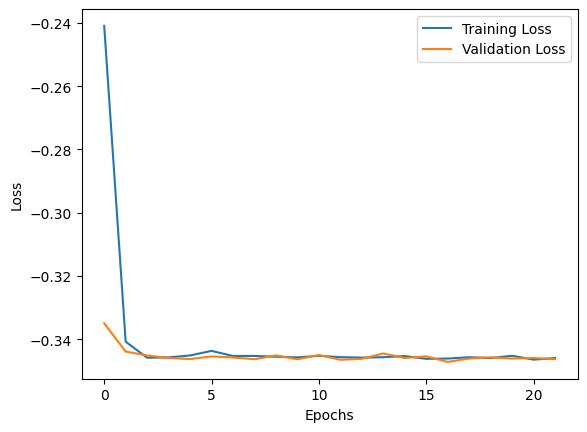

yay
Epoch 1/50
23/23 [==============================] - 85s 4s/step - loss: -0.3467 - pearson_metric: 0.3467 - val_loss: -0.3395 - val_pearson_metric: 0.3395
Epoch 2/50
23/23 [==============================] - 55s 2s/step - loss: -0.3464 - pearson_metric: 0.3464 - val_loss: -0.3408 - val_pearson_metric: 0.3408
Epoch 3/50
23/23 [==============================] - 50s 2s/step - loss: -0.3474 - pearson_metric: 0.3474 - val_loss: -0.3385 - val_pearson_metric: 0.3385
Epoch 4/50
23/23 [==============================] - 52s 2s/step - loss: -0.3471 - pearson_metric: 0.3471 - val_loss: -0.3406 - val_pearson_metric: 0.3406
Epoch 5/50
23/23 [==============================] - 56s 2s/step - loss: -0.3474 - pearson_metric: 0.3474 - val_loss: -0.3411 - val_pearson_metric: 0.3411
Epoch 6/50
23/23 [==============================] - 52s 2s/step - loss: -0.3475 - pearson_metric: 0.3475 - val_loss: -0.3394 - val_pearson_metric: 0.3394
Epoch 7/50
23/23 [==============================] - 50s 2s/step - loss: 

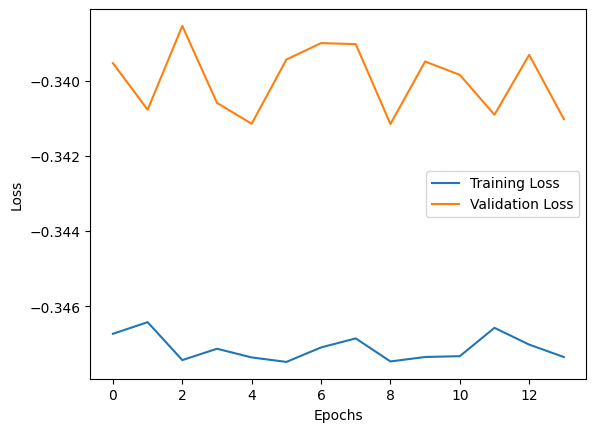

yay
Epoch 1/50
23/23 [==============================] - 94s 4s/step - loss: -0.3442 - pearson_metric: 0.3442 - val_loss: -0.3494 - val_pearson_metric: 0.3494
Epoch 2/50
23/23 [==============================] - 55s 2s/step - loss: -0.3454 - pearson_metric: 0.3454 - val_loss: -0.3491 - val_pearson_metric: 0.3491
Epoch 3/50
23/23 [==============================] - 52s 2s/step - loss: -0.3453 - pearson_metric: 0.3453 - val_loss: -0.3493 - val_pearson_metric: 0.3493
Epoch 4/50
23/23 [==============================] - 56s 2s/step - loss: -0.3448 - pearson_metric: 0.3448 - val_loss: -0.3496 - val_pearson_metric: 0.3496
Epoch 5/50
23/23 [==============================] - 52s 2s/step - loss: -0.3461 - pearson_metric: 0.3461 - val_loss: -0.3496 - val_pearson_metric: 0.3496
Epoch 6/50
23/23 [==============================] - 53s 2s/step - loss: -0.3456 - pearson_metric: 0.3456 - val_loss: -0.3491 - val_pearson_metric: 0.3491
Epoch 7/50
23/23 [==============================] - 55s 2s/step - loss: 

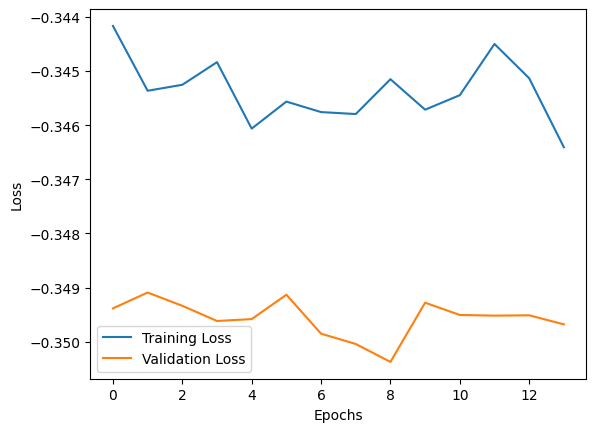

yay
Epoch 1/50
23/23 [==============================] - 89s 4s/step - loss: -0.3453 - pearson_metric: 0.3453 - val_loss: -0.3455 - val_pearson_metric: 0.3455
Epoch 2/50
23/23 [==============================] - 55s 2s/step - loss: -0.3458 - pearson_metric: 0.3458 - val_loss: -0.3405 - val_pearson_metric: 0.3405
Epoch 3/50
23/23 [==============================] - 53s 2s/step - loss: -0.3465 - pearson_metric: 0.3465 - val_loss: -0.3443 - val_pearson_metric: 0.3443
Epoch 4/50
23/23 [==============================] - 51s 2s/step - loss: -0.3466 - pearson_metric: 0.3466 - val_loss: -0.3427 - val_pearson_metric: 0.3427
Epoch 5/50
23/23 [==============================] - 50s 2s/step - loss: -0.3464 - pearson_metric: 0.3464 - val_loss: -0.3438 - val_pearson_metric: 0.3438
Epoch 6/50
16/23 [===================>..........] - ETA: 14s - loss: -0.3493 - pearson_metric: 0.3493

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Sample data and labels
# Your feature data (X) and target labels (y)
X = mega_eeg_list  # Your feature matrix (e.g., NumPy array or Pandas DataFrame)
y = mega_audio_list # Your target labels (e.g., NumPy array or Pandas Series)
# Define the number of folds (K)
k = 5

# Initialize the KFold cross-validator
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize a list to store evaluation scores
scores = []
scores_shuffled = []

count=1
for train_index, val_index in kf.split(X):
    X_train=[]
    y_train=[]
    X_val=[]
    y_val=[]
    y_val_shuffled = []
    for i in train_index:
      X_train.append(X[i])
      y_train.append(y[i])

    for i in val_index:
      X_val.append(X[i])
      y_val.append(y[i])

    # Shuffle the list in-place
    y_val_shuffled = y_val.copy()
    random.shuffle(y_val_shuffled)

    if(y_val == y_val_shuffled ):
      print("Same - abort abort")
    else:
      print("yay")

    # X_train, X_val = X[train_index], X[val_index]
    # y_train, y_val = y[train_index], y[val_index]
    # Train your model on X_train and y_train
    results_folder="/content/drive/MyDrive/CAPSTONE_626_645_648_651/Code/Reconstruction/Model/cnn/Without_SCE_adam_50epochs_32batch_size"
    model_path=results_folder+ f'/model_{count}.h5'
    epochs=50
    batch_size=32
    patience=5
    training_log_filename= f'training_log_{count}.csv'

    history=cnn_model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True),
            tf.keras.callbacks.CSVLogger(os.path.join(results_folder, training_log_filename)),
            tf.keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True),
        ],
        )
    count+=1

    # Make predictions on X_val
    y_pred = cnn_model.predict(X_val)



    # Evaluate the model and store the score
    score = pearson_correlation(y_val, y_pred)
    scores.append(score)

    print("scores->",scores)

    # Evaluate the model and store the score
    score_shuffled = pearson_correlation(y_val_shuffled, y_pred)
    scores_shuffled.append(score_shuffled)
    print("scores_shuffled->",scores_shuffled)

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()




In [ ]:
# Calculate the average score
average_score = sum(scores) / len(scores)
average_score_shuffled = sum(scores_shuffled) / len(scores_shuffled)

print("Average Accuracy:", average_score)
print("Average Accuracy shuffled:", average_score_shuffled)

Average Accuracy: 0.2591593030278361
Average Accuracy shuffled: 0.2591592871503903


In [ ]:
print(type(scores[0]),len(scores))
print(sum(scores))

In [ ]:
scores

[0.24461453300601654,
 0.25949383481103966,
 0.26521657737132864,
 0.27959261560157334,
 0.24687895434922214]

In [ ]:
scores_shuffled

[0.24461358250319998,
 0.2594934125040601,
 0.26521770680721535,
 0.2795927202695784,
 0.24687901366789766]

In [ ]:
mean_scores = np.array(scores).mean()
std_scores = np.array(scores).std()
print(f"Mean Accuracy: {mean_scores:.2f}​​")
print(f"Standard Deviation: {std_scores:.2f}​​")

Mean Accuracy: 0.26​​
Standard Deviation: 0.01​​


In [ ]:
mean_scores = np.array(scores_shuffled).mean()
std_scores = np.array(scores_shuffled).std()
print(f"Mean Accuracy: {mean_scores:.2f}​​")
print(f"Standard Deviation: {std_scores:.2f}​​")

Mean Accuracy: 0.26​​
Standard Deviation: 0.01​​
